In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/initialization')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr import FcIPLLR
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.dataset.mnist import load_data
from utils.abc_params.debug_ipllr import *

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### Load basic configuration and define variables 

In [6]:
N_TRIALS = 1
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 512
base_lr = 0.1
n_steps = 50
tol = 1.0e-8
activation = 'elu'

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [7]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['activation']['name'] = activation
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': n_warmup_steps,
                                       'calibrate_base_lr': True,
                                       'default_calibration': False}}
        
base_model_config = ModelConfig(config_dict)

### Load data & define model

In [8]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [9]:
full_x = torch.cat([a for a,_ in batches], dim=0)
full_y = torch.cat([b for _,b in batches], dim=0)

### Define model

In [99]:
ipllr = FcIPLLR(base_model_config, n_warmup_steps=12, lr_calibration_batches=batches)

initial base lr : [78.5, 60.934471130371094, 354.9498596191406, 423.7919006347656, 391.56158447265625, 442.0751953125, 103.8568344116211]


In [100]:
ipllr.scheduler.warm_lrs[0] = ipllr.scheduler.warm_lrs[0] * (ipllr.d + 1)

### Save initial model : t=0

In [101]:
ipllr_0 = deepcopy(ipllr)

### Train model one step : t=1

In [102]:
x, y = batches[0]
train_model_one_step(ipllr, x, y, normalize_first=True)
ipllr_1 = deepcopy(ipllr)

input abs mean in training:  0.6915712356567383
loss derivatives for model: tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        ...,
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]])
average training loss for model1 : 2.3025991916656494



### Train model for a second step : t=2

In [103]:
x, y = batches[1]
train_model_one_step(ipllr, x, y, normalize_first=True)
ipllr_2 = deepcopy(ipllr)

input abs mean in training:  0.6986760497093201
loss derivatives for model: tensor([[ 0.0827,  0.1801,  0.1906,  ...,  0.0871,  0.0948,  0.0710],
        [ 0.1542,  0.0599,  0.1014,  ...,  0.0603,  0.0646, -0.9116],
        [ 0.0987, -0.9430,  0.0894,  ...,  0.0638,  0.0743,  0.0902],
        ...,
        [ 0.1245,  0.0513,  0.0791,  ...,  0.0736,  0.0743,  0.0924],
        [ 0.0815,  0.1816,  0.1866,  ...,  0.0871,  0.0959,  0.0725],
        [-0.9164,  0.1574,  0.1659,  ...,  0.1027,  0.1021,  0.0746]])
average training loss for model1 : 2.2241616249084473



In [104]:
ipllr.eval()
ipllr_0.eval()
ipllr_1.eval()
ipllr_2.eval()
print()

In [39]:
layer_scales = ipllr.layer_scales
intermediate_layer_keys = ["layer_{:,}_intermediate".format(l) for l in range(2, L + 1)]

### Define W0 and b0

In [105]:
with torch.no_grad():
    W0 = {1: layer_scales[0] * ipllr_0.input_layer.weight.data.detach() / math.sqrt(ipllr_0.d + 1)}
    for i, l in enumerate(range(2, L + 1)):
        layer = getattr(ipllr_0.intermediate_layers, intermediate_layer_keys[i])
        W0[l] = layer_scales[l-1] * layer.weight.data.detach()

    W0[L+1] = layer_scales[L] * ipllr_0.output_layer.weight.data.detach()

In [106]:
with torch.no_grad():
    b0 = layer_scales[0] * ipllr_0.input_layer.bias.data.detach() / math.sqrt(ipllr_0.d + 1)

### Define Delta_W_1 and Delta_b_1

In [107]:
with torch.no_grad():
    Delta_W_1 = {1: layer_scales[0] * (ipllr_1.input_layer.weight.data.detach() -
                                       ipllr_0.input_layer.weight.data.detach()) / math.sqrt(ipllr_1.d + 1)}
    for i, l in enumerate(range(2, L + 1)):
        layer_1 = getattr(ipllr_1.intermediate_layers, intermediate_layer_keys[i])
        layer_0 = getattr(ipllr_0.intermediate_layers, intermediate_layer_keys[i])
        Delta_W_1[l] = layer_scales[l-1] * (layer_1.weight.data.detach() -
                                            layer_0.weight.data.detach())

    Delta_W_1[L+1] = layer_scales[L] * (ipllr_1.output_layer.weight.data.detach() -
                                        ipllr_0.output_layer.weight.data.detach())

In [108]:
with torch.no_grad():
    Delta_b_1 = layer_scales[0] * (ipllr_1.input_layer.bias.data.detach() -
                                   ipllr_0.input_layer.bias.data.detach()) / math.sqrt(ipllr_1.d + 1)

### Define Delta_W_2

In [109]:
with torch.no_grad():
    Delta_W_2 = {1: layer_scales[0] * (ipllr_2.input_layer.weight.data.detach() -
                                       ipllr_1.input_layer.weight.data.detach()) / math.sqrt(ipllr_2.d + 1)}
    for i, l in enumerate(range(2, L + 1)):
        layer_2 = getattr(ipllr_2.intermediate_layers, intermediate_layer_keys[i])
        layer_1 = getattr(ipllr_1.intermediate_layers, intermediate_layer_keys[i])
        Delta_W_2[l] = layer_scales[l-1] * (layer_2.weight.data.detach() -
                                            layer_1.weight.data.detach())

    Delta_W_2[L+1] = layer_scales[L] * (ipllr_2.output_layer.weight.data.detach() -
                                        ipllr_1.output_layer.weight.data.detach())

In [110]:
with torch.no_grad():
    Delta_b_2 = layer_scales[0] * (ipllr_2.input_layer.bias.data.detach() -
                                   ipllr_1.input_layer.bias.data.detach()) / math.sqrt(ipllr_1.d + 1)

## Explore at step 1

### On all training examples

In [111]:
x, y = full_x, full_y

In [112]:
with torch.no_grad():
    x1 = {0: x}
    h0 = {1: F.linear(x, W0[1], b0)}
    delta_h_1 = {1: F.linear(x, Delta_W_1[1], Delta_b_1)}
    h1 = {1: layer_scales[0] * ipllr_1.input_layer.forward(x) / math.sqrt(ipllr_1.d + 1)}
    x1[1] = ipllr_1.activation(h1[1])

In [113]:
torch.testing.assert_allclose(h0[1] + delta_h_1[1], h1[1], rtol=1e-5, atol=1e-4)

In [114]:
with torch.no_grad():
    for i, l in enumerate(range(2, L + 1)):
        layer_1 = getattr(ipllr_1.intermediate_layers, intermediate_layer_keys[i])
        x = x1[l-1]

        h0[l] =  F.linear(x, W0[l])
        delta_h_1[l] = F.linear(x, Delta_W_1[l])
        
        h1[l] = layer_scales[l-1] * layer_1.forward(x)
        x1[l] = ipllr_1.activation(h1[l])
        
        torch.testing.assert_allclose(h0[l] + delta_h_1[l], h1[l], rtol=1e-5, atol=1e-5)

In [115]:
with torch.no_grad():
    x = x1[L] 
    h0[L+1] = F.linear(x, W0[L+1])
    delta_h_1[L+1] = F.linear(x, Delta_W_1[L+1])
    h1[L+1] = layer_scales[L] * ipllr_1.output_layer.forward(x)
    x1[L+1] = ipllr_1.activation(h1[L+1])
                              
    torch.testing.assert_allclose(h0[L+1] + delta_h_1[L+1], h1[L+1], rtol=1e-5, atol=1e-5)

## Ranks after one step

In [116]:
columns = ['W0', 'Delta_W_1', 'Delta_W_2', 'max']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'

with torch.no_grad():
    for l in df.index:
        df.loc[l, columns] = [torch.matrix_rank(W0[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_1[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_2[l], tol=tol).item(),
                              min(W0[l].shape[0], W0[l].shape[1])]
    
df.loc[:, 'batch_size'] = batch_size
df

,W0,Delta_W_1,Delta_W_2,max,batch_size
layer,,,,,
1,784,759,772,784,512
2,1024,845,518,1024,512
3,1024,993,814,1024,512
4,1024,994,823,1024,512
5,1024,983,800,1024,512
6,1024,986,803,1024,512
7,10,10,9,10,512


In [95]:
columns = ['W0', 'Delta_W_1', 'Delta_W_2', 'max']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'

with torch.no_grad():
    for l in df.index:
        df.loc[l, columns] = [torch.matrix_rank(W0[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_1[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_2[l], tol=tol).item(),
                              min(W0[l].shape[0], W0[l].shape[1])]
    
df.loc[:, 'batch_size'] = batch_size
df

,W0,Delta_W_1,Delta_W_2,max,batch_size
layer,,,,,
1,784,770,0,784,512
2,1024,846,0,1024,512
3,1024,684,1,1024,512
4,1024,683,5,1024,512
5,1024,762,1,1024,512
6,1024,875,1,1024,512
7,10,3,1,10,512


In [73]:
columns = ['W0', 'Delta_W_1', 'Delta_W_2', 'max']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'

with torch.no_grad():
    for l in df.index:
        df.loc[l, columns] = [torch.matrix_rank(W0[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_1[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_2[l], tol=tol).item(),
                              min(W0[l].shape[0], W0[l].shape[1])]
    
df.loc[:, 'batch_size'] = batch_size
df

,W0,Delta_W_1,Delta_W_2,max,batch_size
layer,,,,,
1,784,784,784,784,512
2,1024,985,766,1024,512
3,1024,1003,904,1024,512
4,1024,997,894,1024,512
5,1024,995,878,1024,512
6,1024,998,881,1024,512
7,10,10,9,10,512


In [52]:
columns = ['W0', 'Delta_W_1', 'Delta_W_2', 'max']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'

with torch.no_grad():
    for l in df.index:
        df.loc[l, columns] = [torch.matrix_rank(W0[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_1[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_2[l], tol=tol).item(),
                              min(W0[l].shape[0], W0[l].shape[1])]
    
df.loc[:, 'batch_size'] = batch_size
df

,W0,Delta_W_1,Delta_W_2,max,batch_size
layer,,,,,
1,784,784,784,784,512
2,1024,718,513,1024,512
3,1024,983,736,1024,512
4,1024,998,789,1024,512
5,1024,1000,831,1024,512
6,1024,982,754,1024,512
7,10,10,9,10,512


In [74]:
columns = ['W0', 'Delta_W_1', 'Delta_W_2', 'max']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'

with torch.no_grad():
    for l in df.index:
        df.loc[l, columns] = [torch.matrix_rank(W0[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_1[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_2[l], tol=tol).item(),
                              min(W0[l].shape[0], W0[l].shape[1])]
    
df.loc[:, 'batch_size'] = batch_size
df

,W0,Delta_W_1,Delta_W_2,max,batch_size
layer,,,,,
1,784,784,784,784,512
2,1024,985,766,1024,512
3,1024,1003,904,1024,512
4,1024,997,894,1024,512
5,1024,995,878,1024,512
6,1024,998,881,1024,512
7,10,10,9,10,512


In [27]:
columns = ['W0', 'Delta_W_1', 'Delta_W_2', 'max']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'

with torch.no_grad():
    for l in df.index:
        df.loc[l, columns] = [torch.matrix_rank(W0[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_1[l], tol=tol).item(), 
                              torch.matrix_rank(Delta_W_2[l], tol=tol).item(),
                              min(W0[l].shape[0], W0[l].shape[1])]
    
df.loc[:, 'batch_size'] = batch_size
df

,W0,Delta_W_1,Delta_W_2,max,batch_size
layer,,,,,
1,784,783,770,784,512
2,1024,643,350,1024,512
3,1024,708,57,1024,512
4,1024,689,16,1024,512
5,1024,681,12,1024,512
6,1024,683,11,1024,512
7,10,9,3,10,512


In [117]:
columns = ['h0', 'delta_h_1', 'h1']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'
bs = x.shape[0]

for l in df.index:
    maxes = dict()
    
    _, maxes['h0'] = torch.max(h0[l] , dim=1)
    _, maxes['delta_h_1'] = torch.max(delta_h_1[l] , dim=1)
    _, maxes['h1'] = torch.max(h1[l] , dim=1)

    df.loc[l, columns] = [maxes[key].unique().numel() for key in columns]
    df.loc[l, 'max'] = min(bs, h0[l].shape[1])
    
df.loc[:, 'batch_size'] = bs
df.loc[:, 'max'] = df.loc[:, 'max'].astype(int)
df

,h0,delta_h_1,h1,max,batch_size
layer,,,,,
1,741,118,287,1024,60000
2,275,116,121,1024,60000
3,127,106,105,1024,60000
4,91,94,93,1024,60000
5,90,91,89,1024,60000
6,88,61,62,1024,60000
7,9,7,9,10,60000


In [96]:
columns = ['h0', 'delta_h_1', 'h1']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'
bs = x.shape[0]

for l in df.index:
    maxes = dict()
    
    _, maxes['h0'] = torch.max(h0[l] , dim=1)
    _, maxes['delta_h_1'] = torch.max(delta_h_1[l] , dim=1)
    _, maxes['h1'] = torch.max(h1[l] , dim=1)

    df.loc[l, columns] = [maxes[key].unique().numel() for key in columns]
    df.loc[l, 'max'] = min(bs, h0[l].shape[1])
    
df.loc[:, 'batch_size'] = bs
df.loc[:, 'max'] = df.loc[:, 'max'].astype(int)
df

,h0,delta_h_1,h1,max,batch_size
layer,,,,,
1,741,156,740,1024,60000
2,57,1,1,1024,60000
3,5,1,1,1024,60000
4,1,1,1,1024,60000
5,1,1,1,1024,60000
6,1,1,1,1024,60000
7,1,1,1,10,60000


In [75]:
columns = ['h0', 'delta_h_1', 'h1']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'
bs = x.shape[0]

for l in df.index:
    maxes = dict()
    
    _, maxes['h0'] = torch.max(h0[l] , dim=1)
    _, maxes['delta_h_1'] = torch.max(delta_h_1[l] , dim=1)
    _, maxes['h1'] = torch.max(h1[l] , dim=1)

    df.loc[l, columns] = [maxes[key].unique().numel() for key in columns]
    df.loc[l, 'max'] = min(bs, h0[l].shape[1])
    
df.loc[:, 'batch_size'] = bs
df.loc[:, 'max'] = df.loc[:, 'max'].astype(int)
df

,h0,delta_h_1,h1,max,batch_size
layer,,,,,
1,175,47,62,512,512
2,88,80,78,512,512
3,64,58,55,512,512
4,50,54,57,512,512
5,57,37,38,512,512
6,48,33,32,512,512
7,7,7,7,10,512


In [53]:
columns = ['h0', 'delta_h_1', 'h1']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'
bs = x.shape[0]

for l in df.index:
    maxes = dict()
    
    _, maxes['h0'] = torch.max(h0[l] , dim=1)
    _, maxes['delta_h_1'] = torch.max(delta_h_1[l] , dim=1)
    _, maxes['h1'] = torch.max(h1[l] , dim=1)

    df.loc[l, columns] = [maxes[key].unique().numel() for key in columns]
    df.loc[l, 'max'] = min(bs, h0[l].shape[1])
    
df.loc[:, 'batch_size'] = bs
df.loc[:, 'max'] = df.loc[:, 'max'].astype(int)
df

,h0,delta_h_1,h1,max,batch_size
layer,,,,,
1,699,46,357,1024,60000
2,320,27,34,1024,60000
3,49,10,10,1024,60000
4,26,19,21,1024,60000
5,27,17,17,1024,60000
6,22,8,6,1024,60000
7,4,5,6,10,60000


In [423]:
columns = ['h0', 'delta_h_1', 'h1']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'
bs = x.shape[0]

for l in df.index:
    maxes = dict()
    
    _, maxes['h0'] = torch.max(h0[l] , dim=1)
    _, maxes['delta_h_1'] = torch.max(delta_h_1[l] , dim=1)
    _, maxes['h1'] = torch.max(h1[l] , dim=1)

    df.loc[l, columns] = [maxes[key].unique().numel() for key in columns]
    df.loc[l, 'max'] = min(bs, h0[l].shape[1])
    
df.loc[:, 'batch_size'] = bs
df.loc[:, 'max'] = df.loc[:, 'max'].astype(int)
df

,h0,delta_h_1,h1,max,batch_size
layer,,,,,
1,716,44,267,1024,60000
2,142,6,6,1024,60000
3,6,1,1,1024,60000
4,1,1,1,1024,60000
5,1,1,1,1024,60000
6,1,1,1,1024,60000
7,1,1,1,10,60000


In [29]:
print(Delta_W_1[1].shape)
print(torch.matrix_rank(Delta_W_1[1], tol=tol))

torch.Size([1024, 784])
tensor(783)


In [32]:
print(Delta_W_1[1].shape)
print(torch.matrix_rank(Delta_W_1[1], tol=1e-4))

torch.Size([1024, 784])
tensor(509)


In [34]:
print(Delta_W_1[1].shape)
print(torch.matrix_rank(Delta_W_1[1]))

torch.Size([1024, 784])
tensor(492)


In [36]:
import sympy

In [39]:
m = sympy.Matrix(Delta_W_1[1].numpy().tolist()).rref()

KeyboardInterrupt: 

In [ ]:
len(m[1])

In [359]:
dic = {p: torch.matrix_rank(W0[1], tol=10**(-p)).item() for p in range(0, 10)}
print(dic)

{0: 526, 1: 784, 2: 784, 3: 784, 4: 784, 5: 784, 6: 784, 7: 784, 8: 784, 9: 784}


In [400]:
l = 4
dic = {p: torch.matrix_rank(h1[l], tol=10**(-p)).item() for p in range(0, 10)}
dic

{0: 9,
 1: 38,
 2: 187,
 3: 485,
 4: 622,
 5: 1024,
 6: 1024,
 7: 1024,
 8: 1024,
 9: 1024}

In [401]:
np.array(list(dic.values())).mean()

646.1

In [402]:
torch.matrix_rank(h1[l]).item()

1

In [637]:
l = 4
dic = {p: torch.matrix_rank(x1[l], tol=10**(-p)).item() for p in range(0, 10)}
dic

{0: 8, 1: 31, 2: 147, 3: 392, 4: 486, 5: 486, 6: 487, 7: 489, 8: 502, 9: 590}

In [638]:
np.array(list(dic.values())).mean()

361.8

In [639]:
torch.matrix_rank(x1[l]).item()

1

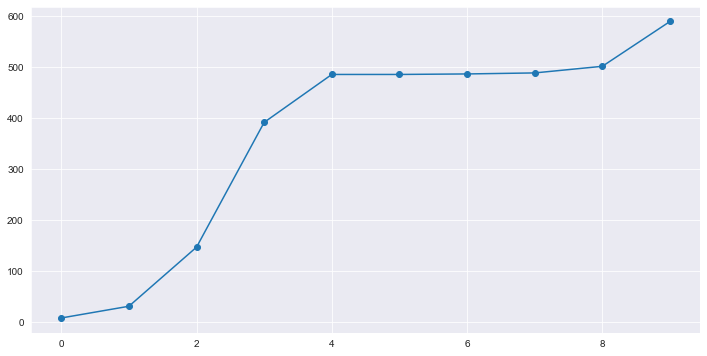

In [640]:
plt.figure(figsize=(12,6))
plt.plot(dic.keys(), dic.values(), marker='o')
plt.show()

In [641]:
l = 5
dic = {p: torch.matrix_rank(x1[l], tol=10**(-p)).item() for p in range(0, 10)}
dic

{0: 3, 1: 7, 2: 18, 3: 77, 4: 279, 5: 486, 6: 486, 7: 488, 8: 489, 9: 499}

In [642]:
np.array(list(dic.values())).mean()

283.2

In [643]:
torch.matrix_rank(x1[l]).item()

1

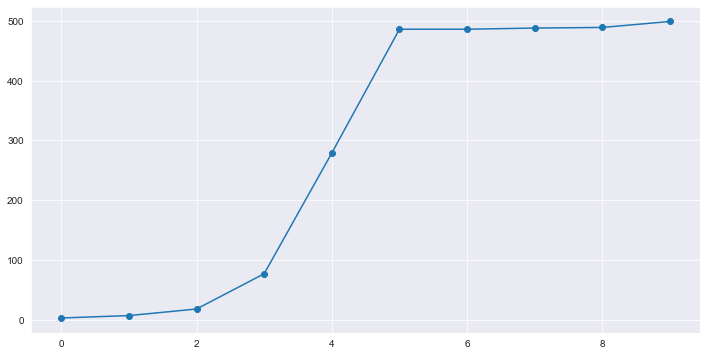

In [644]:
plt.figure(figsize=(12,6))
plt.plot(dic.keys(), dic.values(), marker='o')
plt.show()

In [645]:
u,s,v = torch.svd(x1[l], compute_uv=False)
s

tensor([8.2177e+03, 6.9586e+00, 1.2103e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])

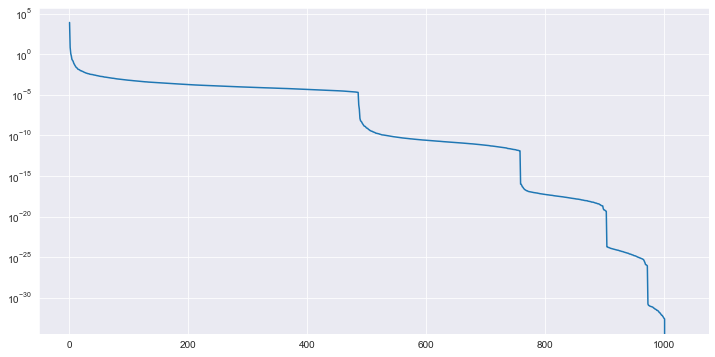

In [646]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(s)+1), s)
plt.yscale('log')
plt.show()

In [647]:
l = 6
dic = {p: torch.matrix_rank(x1[l], tol=10**(-p)).item() for p in range(0, 10)}
dic

{0: 2, 1: 3, 2: 6, 3: 17, 4: 104, 5: 451, 6: 501, 7: 502, 8: 503, 9: 505}

In [648]:
np.array(list(dic.values())).mean()

259.4

In [649]:
torch.matrix_rank(x1[l]).item()

1

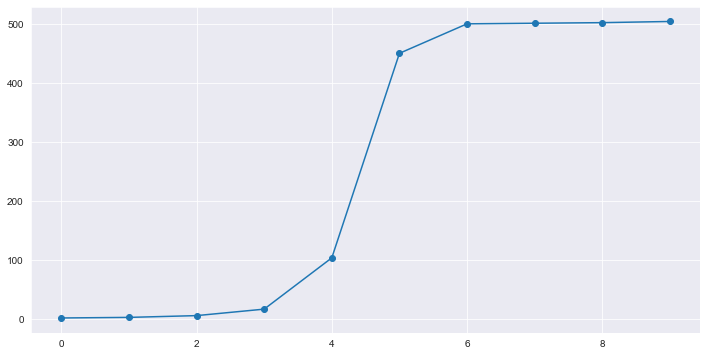

In [650]:
plt.figure(figsize=(12,6))
plt.plot(dic.keys(), dic.values(), marker='o')
plt.show()

In [651]:
u,s,v = torch.svd(x1[l], compute_uv=False)
s

tensor([8.4568e+03, 1.4732e+00, 1.1934e-01,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])

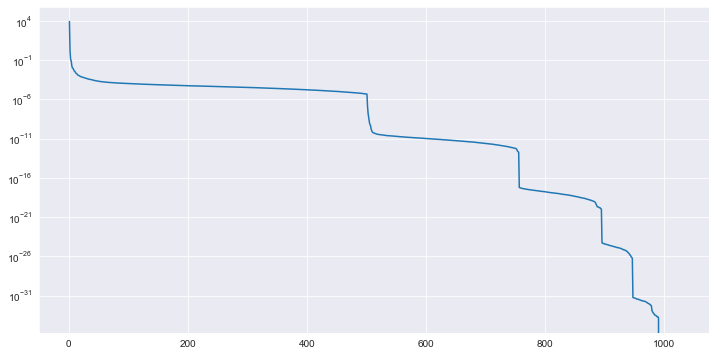

In [652]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(s)+1), s)
plt.yscale('log')
plt.show()

In [653]:
l = 7
dic = {p: torch.matrix_rank(h1[l], tol=10**(-p)).item() for p in range(0, 10)}
dic

{0: 1, 1: 1, 2: 2, 3: 4, 4: 6, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10}

In [654]:
np.array(list(dic.values())).mean()

6.4

In [655]:
torch.matrix_rank(h1[l]).item()

1

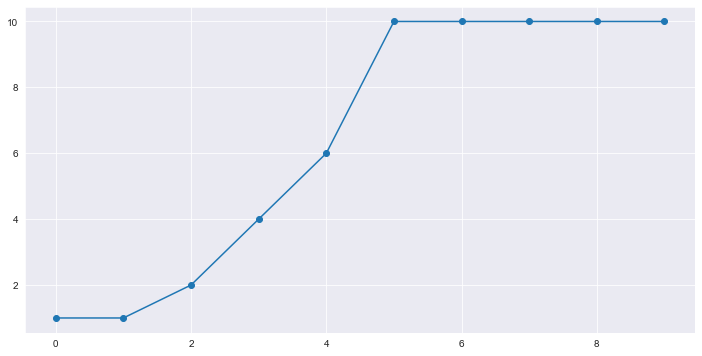

In [656]:
plt.figure(figsize=(12,6))
plt.plot(dic.keys(), dic.values(), marker='o')
plt.show()

In [657]:
u,s,v = torch.svd(h1[l], compute_uv=False)
s

tensor([2.0597e+02, 2.8338e-02, 1.8068e-03, 1.3662e-03, 2.9127e-04, 1.5903e-04,
        9.0443e-05, 7.2283e-05, 4.7972e-05, 2.7555e-05])

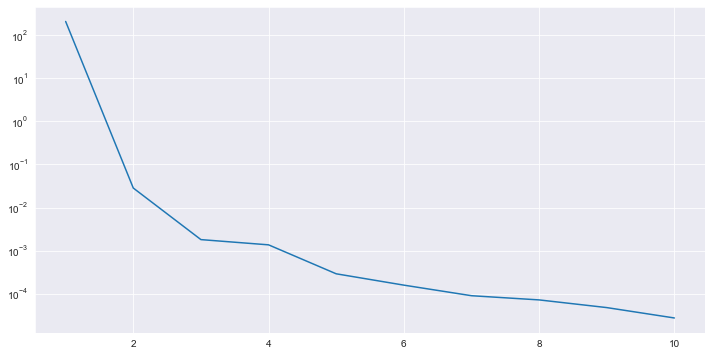

In [658]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(s)+1), s)
plt.yscale('log')
plt.show()

In [665]:
i = 87
h_0 = h1[7][0]
h_i = h1[7][i]
print(h_0.shape)
print(h_i.shape)

torch.Size([10])
torch.Size([10])


In [666]:
ratios = np.array([h_i[j].item() / h_0[j].item() for j in range(len(h_0))])
ratios[:10]

array([0.91868981, 0.91891091, 0.91619078, 0.91792938, 0.91907079,
       0.91844939, 0.91854038, 0.91843178, 0.91850088, 0.91876918])

In [667]:
ratios.max()

0.9190707920578237

In [668]:
ratios.min()

0.9161907795785011

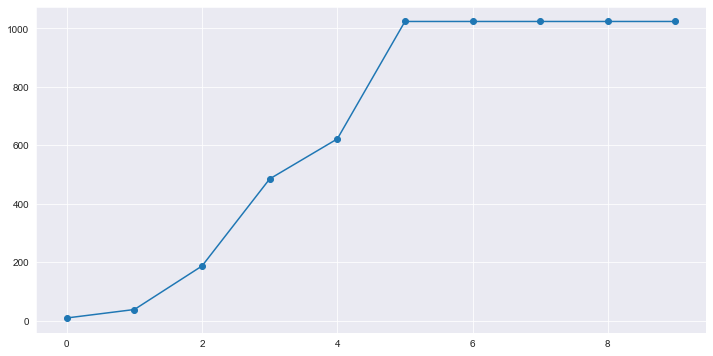

In [403]:
plt.figure(figsize=(12,6))
plt.plot(dic.keys(), dic.values(), marker='o')
plt.show()

In [404]:
u,s,v = torch.svd(h1[l], compute_uv=False)
s

tensor([1.1243e+04, 5.5877e+01, 1.3726e+01,  ..., 1.3762e-05, 1.3630e-05,
        1.2910e-05])

In [405]:
(s ** 2).sum().sqrt()

tensor(11243.0605)

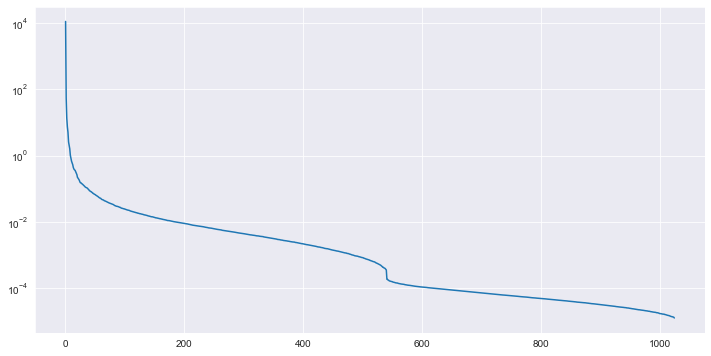

In [406]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(s)+1), s)
plt.yscale('log')
plt.show()

In [407]:
torch.frobenius_norm(h1[l])

tensor(10901.3262)

In [408]:
torch.frobenius_norm(h1[l]) / (s ** 2).sum().sqrt()

tensor(0.9696)

In [409]:
torch.nuclear_norm(h1[l])

tensor(11345.9492)

In [450]:
h = h1[7]
h.shape

torch.Size([60000, 10])

In [460]:
i = 2
h_0 = h[0]
h_i = h[i]
print(h_0.shape)
print(h_i.shape)

torch.Size([10])
torch.Size([10])


In [461]:
ratios = np.array([h_i[j].item() / h_0[j].item() for j in range(len(h_0))])
ratios[:10]

array([0.95758819, 0.95784505, 0.95462631, 0.9572414 , 0.95810498,
       0.95729943, 0.95746524, 0.95719659, 0.95738072, 0.95771755])

In [462]:
ratios.max()

0.9581049849977904

In [463]:
ratios.min()

0.954626312910875

In [630]:
i = 2
h_0 = x1[3][0]
h_i = x1[3][i]
print(h_0.shape)
print(h_i.shape)

torch.Size([1024])
torch.Size([1024])


In [631]:
a0 = (np.argwhere(h_0.numpy() == 0))
len(a0)

512

In [632]:
ai = np.argwhere(h_i.numpy() == 0)
len(ai)

508

In [634]:
ratios = np.array([h_i[j].item() / h_0[j].item() for j in range(len(h_0)) if h_0[j].item() != 0])
ratios[:10]

array([1.02592166, 0.85666805, 0.7986458 , 1.19214978, 2.07869602,
       1.03727692, 0.9650415 , 0.98351098, 1.07760287, 0.94662943])

In [635]:
ratios.max()

21.927943372507993

In [636]:
ratios.min()

0.0

In [ ]:
a = 2
a

In [ ]:
x =3

In [423]:
columns = ['h0', 'delta_h_1', 'h1']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'
bs = x.shape[0]

for l in df.index:
    maxes = dict()
    
    _, maxes['h0'] = torch.max(h0[l] , dim=1)
    _, maxes['delta_h_1'] = torch.max(delta_h_1[l] , dim=1)
    _, maxes['h1'] = torch.max(h1[l] , dim=1)

    df.loc[l, columns] = [maxes[key].unique().numel() for key in columns]
    df.loc[l, 'max'] = min(bs, h0[l].shape[1])
    
df.loc[:, 'batch_size'] = bs
df.loc[:, 'max'] = df.loc[:, 'max'].astype(int)
df

,h0,delta_h_1,h1,max,batch_size
layer,,,,,
1,716,44,267,1024,60000
2,142,6,6,1024,60000
3,6,1,1,1024,60000
4,1,1,1,1024,60000
5,1,1,1,1024,60000
6,1,1,1,1024,60000
7,1,1,1,10,60000


In [51]:
a = 2
a

2

In [ ]:
x =3

In [423]:
columns = ['h0', 'delta_h_1', 'h1']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'
bs = x.shape[0]

for l in df.index:
    maxes = dict()
    
    _, maxes['h0'] = torch.max(h0[l] , dim=1)
    _, maxes['delta_h_1'] = torch.max(delta_h_1[l] , dim=1)
    _, maxes['h1'] = torch.max(h1[l] , dim=1)

    df.loc[l, columns] = [maxes[key].unique().numel() for key in columns]
    df.loc[l, 'max'] = min(bs, h0[l].shape[1])
    
df.loc[:, 'batch_size'] = bs
df.loc[:, 'max'] = df.loc[:, 'max'].astype(int)
df

,h0,delta_h_1,h1,max,batch_size
layer,,,,,
1,716,44,267,1024,60000
2,142,6,6,1024,60000
3,6,1,1,1024,60000
4,1,1,1,1024,60000
5,1,1,1,1024,60000
6,1,1,1,1024,60000
7,1,1,1,10,60000


In [704]:
_, maxes = torch.max(full_x , dim=1)
len(maxes.unique())

554

In [516]:
W = Delta_W_1[3]
W.shape

torch.Size([1024, 1024])

In [517]:
h = h1[3]
h.shape

torch.Size([60000, 1024])

In [518]:
dic = {p: torch.matrix_rank(W, tol=10**(-p)).item() for p in range(0, 10)}
print(dic)
print('')
torch.matrix_rank(W).item()

{0: 3, 1: 27, 2: 302, 3: 511, 4: 512, 5: 512, 6: 512, 7: 523, 8: 708, 9: 951}



512

In [519]:
dic = {p: torch.matrix_rank(h, tol=10**(-p)).item() for p in range(0, 10)}
print(dic)
print('')
print(torch.matrix_rank(h).item())

{0: 56, 1: 401, 2: 650, 3: 698, 4: 763, 5: 1024, 6: 1024, 7: 1024, 8: 1024, 9: 1024}

3


In [520]:
u,s,v = torch.svd(h, compute_uv=False)
s

tensor([1.1235e+04, 3.4179e+02, 1.1119e+02,  ..., 2.3045e-05, 2.2508e-05,
        2.2153e-05])

In [521]:
(s ** 2).sum().sqrt()

tensor(11241.1641)

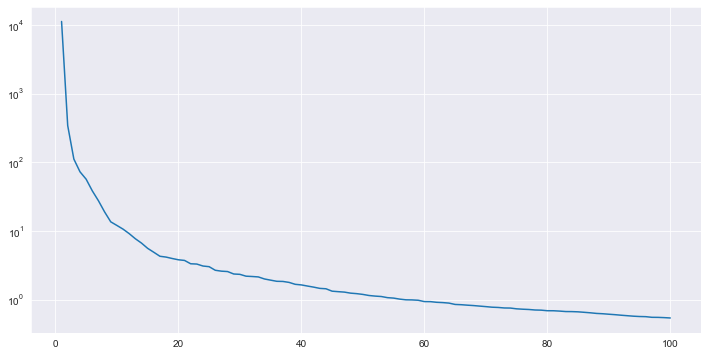

In [522]:
N = 100
plt.figure(figsize=(12,6))
plt.plot(range(1, N+1), s[:N])
plt.yscale('log')
plt.show()

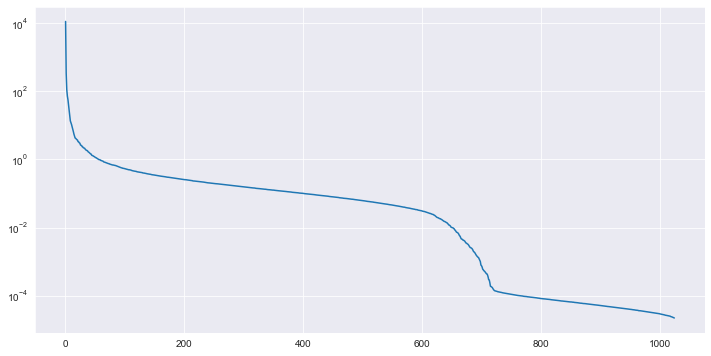

In [523]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(s)+1), s)
plt.yscale('log')
plt.show()

In [524]:
_, maxes = torch.max(h , dim=1)
maxes

tensor([754, 754, 754,  ..., 754, 754, 754])

In [558]:
i = 0
print(h[0, 657].item(), h[0, 754].item())

-6.416260242462158 5.749668121337891


In [525]:
maxes.unique(return_counts=True)

(tensor([754]), tensor([60000]))

In [526]:
linf_norms = W.abs().max(dim=1)
linf_norms.values

tensor([0.0141, 0.0065, 0.0164,  ..., 0.0014, 0.0177, 0.0151])

In [570]:
linf_norms = W.max(dim=1)
linf_norms.values.shape

values, maxes = torch.sort(linf_norms.values, descending=True)
maxes

maxes[:50]

tensor([ 754,  998,  280,  627,  137,  731,  303,  683,  101,  602,  507,  244,
         464,  211,  673,  778, 1000,  680,  563,  295,  257,  536,  557,  356,
         763,   98,  846,  556,  925,  686,  897,  515,  512,   61,  119,  982,
         438,  751,  619,  212,  117,  738,  122,  538,  347,  767,  928,  961,
          42,  108])

In [580]:
linf_norms = h1[2].max(dim=1)
linf_norms.values.shape

values, maxes = torch.sort(linf_norms.values, descending=True)
maxes

maxes[:50]

tensor([30428, 42413, 11748, 47140, 46554, 18332, 17509, 53473, 44261, 20751,
        28919,  4062, 27159, 42931,  2830, 49962,  3102, 42983, 40811, 38897,
         2883,  7554, 52574, 54985, 38979, 19345, 56676,  7710, 41529,  5316,
         2414, 11648, 15639, 10186, 17811, 53304, 59891,  2932, 22507, 52116,
        57073, 36986, 43846, 13492, 21366, 14115, 49705, 22572, 41270, 41362])

In [581]:
linf_norms.indices

tensor([814, 797, 797,  ..., 814, 797, 340])

In [576]:
values

tensor([0.0515, 0.0402, 0.0384,  ..., 0.0000, 0.0000, 0.0000])

In [571]:
linf_norms.indices

tensor([975, 679, 129,  ..., 195, 784, 814])

In [577]:
W[754, 975]

tensor(0.0056)

In [578]:
linf_norms.values[754]

tensor(0.0515)

In [579]:
linf_norms.indices[754]

tensor(1021)

In [573]:
linf_norms.indices

tensor([975, 679, 129,  ..., 195, 784, 814])

In [574]:
linf_norms

torch.return_types.max(
values=tensor([0.0039, 0.0065, 0.0164,  ..., 0.0014, 0.0126, 0.0100]),
indices=tensor([975, 679, 129,  ..., 195, 784, 814]))

In [575]:
W.max()

tensor(0.0515)

In [561]:
W[754, 975]

tensor(0.0056)

In [562]:
W[998, 679]

tensor(0.0066)

In [563]:
W[280, 129]

tensor(0.0264)

In [527]:
linf_norms = W.abs().max(dim=1)
linf_norms.values.shape

values, maxes = torch.sort(linf_norms.values, descending=True)
maxes

maxes[:50]

tensor([ 657,  754,  823,  617,  882,  242,  998,  577,  855,  373,  280,  838,
         627,  260,  636,  580,  137,  731,  908,  816,  187,  408,  303,  683,
         926,  101,  622,   63,  602,  507,  390,  583,  244,  464,  211,  794,
         887,  673,    8,  516,  773,  778,   33, 1000,  741,  993,  680,  563,
         295,  651])

In [530]:
values[:50]

tensor([0.3783, 0.3462, 0.3375, 0.3253, 0.2895, 0.2720, 0.2692, 0.2554, 0.2528,
        0.2526, 0.2507, 0.2504, 0.2484, 0.2476, 0.2474, 0.2460, 0.2436, 0.2420,
        0.2404, 0.2403, 0.2353, 0.2345, 0.2339, 0.2336, 0.2334, 0.2330, 0.2327,
        0.2311, 0.2292, 0.2290, 0.2275, 0.2266, 0.2230, 0.2226, 0.2221, 0.2201,
        0.2199, 0.2194, 0.2188, 0.2187, 0.2181, 0.2172, 0.2166, 0.2153, 0.2142,
        0.2137, 0.2130, 0.2127, 0.2125, 0.2106])

In [534]:
h[:5, :5]

tensor([[-1.3466,  0.1391,  0.9697, -0.3696,  0.1199],
        [-1.9667,  0.1638,  1.1092, -0.5825,  0.1314],
        [-1.3984,  0.1427,  0.8307, -0.3721,  0.0957],
        [-0.9939,  0.1019,  0.5777, -0.2629,  0.0661],
        [-1.5549,  0.1679,  1.0500, -0.4382,  0.1311]])

In [535]:
W_signs = (W > 0)
W_signs[:5, :5]

tensor([[False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False,  True,  True, False],
        [False, False,  True, False, False],
        [ True,  True,  True,  True,  True]])

In [538]:
h_signs = (h > 0)
h_signs[:10, :10]

tensor([[False,  True,  True, False,  True,  True, False, False, False, False],
        [False,  True,  True, False,  True,  True,  True, False, False, False],
        [False,  True,  True, False,  True,  True,  True, False, False, False],
        [False,  True,  True, False,  True,  True,  True, False, False, False],
        [False,  True,  True, False,  True,  True,  True, False, False, False],
        [False,  True,  True, False,  True,  True, False, False, False, False],
        [False,  True,  True, False,  True,  True,  True, False, False, False],
        [False,  True,  True, False,  True,  True, False, False, False, False],
        [False,  True,  True, False,  True,  True, False, False, False, False],
        [False,  True,  True, False,  True,  True,  True, False, False, False]])

In [546]:
a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h) for j in range(h.shape[1])])
a.sum() / len(a)

0.9863583333333333

In [589]:
h_signs = (h1[2] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.93598662109375

In [590]:
h_signs = (h1[1] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.7083759114583333

In [591]:
h_signs = (x1[0] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.8240909863945579

In [592]:
h_signs = (h0[1] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.6140643880208334

In [679]:
h_signs = (h1[1] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.7083759114583333

In [683]:
h_neg = (h1[1] <= 0)
a = np.array([(h_neg[:,j] == 1).sum().item() == len(h_neg) for j in range(h_neg.shape[1])])

In [686]:
h_neg[:10, :10]

tensor([[False, False, False, False,  True, False,  True,  True,  True, False],
        [ True,  True, False, False,  True, False, False,  True, False, False],
        [False,  True, False, False, False, False, False,  True, False, False],
        [False,  True,  True,  True, False, False,  True,  True, False, False],
        [False, False, False, False,  True, False, False,  True, False, False],
        [ True,  True, False, False,  True, False, False,  True, False, False],
        [False,  True, False, False, False, False, False,  True, False, False],
        [False,  True, False, False, False, False,  True,  True, False, False],
        [False, False, False, False,  True, False,  True,  True,  True, False],
        [False,  True, False, False,  True, False,  True, False, False, False]])

In [687]:
h_neg.sum(dim=0)

tensor([15922, 32636, 14966,  ..., 36521, 12754, 58675])

In [689]:
h_neg.shape

torch.Size([60000, 1024])

In [690]:
h_neg.sum(dim=0).max()

tensor(59738)

In [691]:
h_neg.sum(dim=0).min()

tensor(5)

In [693]:
x1[4][:10, :10]

tensor([[0.0000, 0.0000, 0.9224, 3.8394, 0.0000, 0.0468, 2.2288, 0.2287, 0.0000,
         0.7728],
        [0.0000, 0.0000, 1.2761, 5.2328, 0.0000, 0.0662, 3.0773, 0.3211, 0.0000,
         1.0442],
        [0.0000, 0.0000, 0.8866, 3.6456, 0.0000, 0.0457, 2.1339, 0.2229, 0.0000,
         0.7291],
        [0.0000, 0.0000, 0.6282, 2.5778, 0.0000, 0.0326, 1.5114, 0.1584, 0.0000,
         0.5154],
        [0.0000, 0.0000, 1.0476, 4.3284, 0.0000, 0.0546, 2.5253, 0.2615, 0.0000,
         0.8708],
        [0.0000, 0.0000, 1.3868, 5.7881, 0.0000, 0.0716, 3.3549, 0.3459, 0.0000,
         1.1684],
        [0.0000, 0.0000, 1.0467, 4.3121, 0.0000, 0.0540, 2.5251, 0.2622, 0.0000,
         0.8628],
        [0.0000, 0.0000, 1.0540, 4.3928, 0.0000, 0.0523, 2.5490, 0.2621, 0.0000,
         0.8808],
        [0.0000, 0.0000, 1.2314, 5.1615, 0.0000, 0.0612, 2.9825, 0.3051, 0.0000,
         1.0425],
        [0.0000, 0.0000, 1.1677, 4.8283, 0.0000, 0.0607, 2.8206, 0.2922, 0.0000,
         0.9697]])

In [694]:
(full_x < 0).sum() / full_x.numel()

tensor(0.8302)

In [ ]:
h_pos = (h1[1] > 0)
a = np.array([(h_pos[:,j] == 1).sum().item() == len(h_signs) for j in range(h_signs.shape[1])])

In [684]:
a

array([False, False, False, ..., False, False, False])

In [685]:
a.sum()

0

In [ ]:
a.sum() / len(a)

In [593]:
h_signs = (h0[2] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.746588623046875

In [594]:
h_signs = (h0[3] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.9240537760416667

In [595]:
h_signs = (h0[4] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.9874080240885417

In [596]:
h_signs = (h0[5] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.9987213053385418

In [597]:
h_signs = (h0[6] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

1.0

In [598]:
h_signs = (h0[7] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

1.0

In [669]:
columns = ['h0', 'delta_h_1', 'h1']
df = pd.DataFrame(columns=columns, index=range(1, L+2))
df.index.name = 'layer'
bs = x.shape[0]

for l in df.index:
    maxes = dict()
    
    _, maxes['h0'] = torch.max(h0[l] , dim=1)
    _, maxes['delta_h_1'] = torch.max(delta_h_1[l] , dim=1)
    _, maxes['h1'] = torch.max(h1[l] , dim=1)

    df.loc[l, columns] = [maxes[key].unique().numel() for key in columns]
    df.loc[l, 'max'] = min(bs, h0[l].shape[1])
    
df.loc[:, 'batch_size'] = bs
df.loc[:, 'max'] = df.loc[:, 'max'].astype(int)
df

,h0,delta_h_1,h1,max,batch_size
layer,,,,,
1,716,44,267,1024,60000
2,142,6,6,1024,60000
3,6,1,1,1024,60000
4,1,1,1,1024,60000
5,1,1,1,1024,60000
6,1,1,1,1024,60000
7,1,1,1,10,60000


In [676]:
W_hats = [torch.randn(width, width) for _ in range(5)]

In [677]:
outs = [F.linear(x1[4], W_hat) for W_hat in W_hats]

In [678]:
for out in outs:
    _, maxes = torch.max(out , dim=1)
    print(maxes.unique())

tensor([664])
tensor([760])
tensor([531])
tensor([427])
tensor([296])


In [599]:
x1[6][:10, :10]

tensor([[1.9358, 0.0000, 0.0635, 0.0000, 0.0000, 1.1817, 0.0000, 1.0702, 0.8698,
         0.6482],
        [2.6674, 0.0000, 0.0877, 0.0000, 0.0000, 1.6283, 0.0000, 1.4748, 1.1978,
         0.8931],
        [1.8533, 0.0000, 0.0609, 0.0000, 0.0000, 1.1314, 0.0000, 1.0247, 0.8323,
         0.6205],
        [1.3124, 0.0000, 0.0431, 0.0000, 0.0000, 0.8012, 0.0000, 0.7256, 0.5893,
         0.4394],
        [2.1937, 0.0000, 0.0720, 0.0000, 0.0000, 1.3391, 0.0000, 1.2128, 0.9854,
         0.7345],
        [2.9134, 0.0000, 0.0955, 0.0000, 0.0000, 1.7784, 0.0000, 1.6106, 1.3091,
         0.9754],
        [2.1908, 0.0000, 0.0720, 0.0000, 0.0000, 1.3373, 0.0000, 1.2112, 0.9840,
         0.7335],
        [2.2129, 0.0000, 0.0726, 0.0000, 0.0000, 1.3509, 0.0000, 1.2235, 0.9944,
         0.7410],
        [2.5897, 0.0000, 0.0849, 0.0000, 0.0000, 1.5809, 0.0000, 1.4317, 1.1640,
         0.8671],
        [2.4471, 0.0000, 0.0803, 0.0000, 0.0000, 1.4938, 0.0000, 1.3529, 1.0993,
         0.8193]])

In [705]:
h_signs = (full_x > 0)

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.8240909863945579

In [707]:
h_signs = (delta_h_1[1] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.8389780436197916

In [708]:
h_signs = (h0[1] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.6140643880208334

In [709]:
h_signs = (h1[1] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.7083759114583333

In [710]:
h_signs = (x1[1] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.7083759114583333

In [720]:
h_signs = (h0[2] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

0.746588623046875

In [ ]:
h_signs = (h1[2] > 0)
h_signs[:10, :10]

a = np.array([(h_signs[:,j] == h_signs[0,j]).sum().item() / len(h_signs) for j in range(h_signs.shape[1])])
a.sum() / len(a)

In [543]:
a.sum()

1010.0309333333333

In [545]:
len(a)

1024

In [548]:
l2_norms = (W ** 2).sum(dim=1).sqrt()
l2_norms.shape

torch.Size([1024])

In [549]:
values, maxes = torch.sort(l2_norms, descending=True)
maxes

tensor([657, 754, 823,  ..., 436, 644, 494])

In [550]:
maxes[:50]

tensor([ 657,  754,  823,  242,  998,  507,  260,  280,  882,  926,  838,    8,
         580,  794,  577,  816,  636,  211, 1000,  622,  855,  887,  778,  373,
         617,  390,  995,  680,  464,   33,  283,  556,  257,  516,  241,  651,
         137,  408,  101,  536,  583,  187,  773,  545,  993,  846,   63,  731,
         538,  281])

In [551]:
values[:50]

tensor([0.3783, 0.3462, 0.3375, 0.3253, 0.2895, 0.2720, 0.2692, 0.2554, 0.2528,
        0.2526, 0.2507, 0.2504, 0.2484, 0.2476, 0.2474, 0.2460, 0.2436, 0.2420,
        0.2404, 0.2403, 0.2353, 0.2345, 0.2339, 0.2336, 0.2334, 0.2330, 0.2327,
        0.2311, 0.2292, 0.2290, 0.2275, 0.2266, 0.2230, 0.2226, 0.2221, 0.2201,
        0.2199, 0.2194, 0.2188, 0.2187, 0.2181, 0.2172, 0.2166, 0.2153, 0.2142,
        0.2137, 0.2130, 0.2127, 0.2125, 0.2106])

In [552]:
values[-50:]

tensor([0.0082, 0.0080, 0.0079, 0.0074, 0.0074, 0.0073, 0.0070, 0.0067, 0.0066,
        0.0061, 0.0056, 0.0055, 0.0054, 0.0052, 0.0052, 0.0050, 0.0049, 0.0049,
        0.0048, 0.0044, 0.0042, 0.0040, 0.0040, 0.0039, 0.0037, 0.0036, 0.0031,
        0.0029, 0.0025, 0.0020, 0.0016, 0.0016, 0.0013, 0.0007, 0.0002, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [553]:
l1_norms = W.abs().sum(dim=1)
l1_norms.shape

torch.Size([1024])

In [554]:
values, maxes = torch.sort(l1_norms, descending=True)
maxes

tensor([657, 754, 823,  ..., 361, 362, 843])

In [555]:
maxes[:50]

tensor([ 657,  754,  823,  242,  998,  507,  260,  577,  280,    8,  838,  882,
         794,  622,  816,  926,  580,  636,  211, 1000,  855,  778,  464,  556,
         617,  390,  373,   33,  887,  680,  995,  283,  516,  137,  583,  257,
         101,  773,  241,  187,  651,  408,  536,  846,  731,  961,  281,  683,
         545,   63])

In [556]:
values[:50]

tensor([8.4229, 7.5635, 7.1007, 6.8295, 6.1158, 5.8719, 5.5750, 5.4961, 5.4619,
        5.4560, 5.4484, 5.4232, 5.3890, 5.3420, 5.3095, 5.2940, 5.2779, 5.1413,
        5.1220, 5.0999, 5.0492, 5.0419, 5.0375, 5.0295, 5.0267, 5.0128, 4.9809,
        4.9723, 4.8863, 4.8682, 4.8120, 4.7842, 4.7711, 4.7551, 4.7441, 4.7099,
        4.6705, 4.6694, 4.6653, 4.6503, 4.6006, 4.5888, 4.5886, 4.5808, 4.5742,
        4.5261, 4.5134, 4.4908, 4.4874, 4.4791])

In [501]:
values[-100:]

tensor([0.3619, 0.3597, 0.3593, 0.3558, 0.3539, 0.3522, 0.3510, 0.3425, 0.3416,
        0.3415, 0.3369, 0.3338, 0.3331, 0.3310, 0.3278, 0.3278, 0.3271, 0.3261,
        0.3247, 0.3236, 0.3231, 0.3222, 0.3194, 0.3194, 0.3173, 0.3130, 0.3081,
        0.3077, 0.3067, 0.2947, 0.2922, 0.2910, 0.2894, 0.2868, 0.2843, 0.2822,
        0.2765, 0.2701, 0.2670, 0.2632, 0.2604, 0.2583, 0.2557, 0.2538, 0.2457,
        0.2439, 0.2400, 0.2333, 0.2278, 0.2273, 0.2245, 0.2217, 0.2176, 0.2165,
        0.2137, 0.2042, 0.1977, 0.1935, 0.1898, 0.1878, 0.1858, 0.1809, 0.1790,
        0.1719, 0.1640, 0.1609, 0.1562, 0.1533, 0.1503, 0.1501, 0.1486, 0.1438,
        0.1403, 0.1380, 0.1368, 0.1338, 0.1132, 0.0846, 0.0799, 0.0779, 0.0775,
        0.0737, 0.0702, 0.0696, 0.0693, 0.0651, 0.0620, 0.0611, 0.0607, 0.0554,
        0.0539, 0.0527, 0.0353, 0.0340, 0.0285, 0.0177, 0.0110, 0.0000, 0.0000,
        0.0000])